<a href="https://colab.research.google.com/github/rudycav/Digital-Assets-Prediction-Model/blob/main/Project/%20Crypto_forecast_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import math
import requests
import pandas as pd
import matplotlib.pylab as plt
#%matplotlib widget
#from google.colab import output
#output.enable_custom_widget_manager()

from datetime import datetime
from datetime import datetime, timedelta
plt.style.use('fivethirtyeight')
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import metrics
from sklearn.svm import SVC
from sklearn import svm
from sklearn.linear_model import LinearRegression
from scipy.stats import sem

In [2]:
#Set cryptocurrency ticker
symbol = 'ETH'

def get_crypto_price(symbol, exchange, start_date = None):
    api_key = ' '
    api_url = f'https://www.alphavantage.co/query?function=DIGITAL_CURRENCY_DAILY&symbol={symbol}&market={exchange}&apikey={api_key}'
    raw_df = requests.get(api_url).json()
    df = pd.DataFrame(raw_df['Time Series (Digital Currency Daily)']).T
    df = df.rename(columns = {'1a. open (USD)': 'open', '2a. high (USD)': 'high', '3a. low (USD)': 'low', '4a. close (USD)': 'close', '5. volume': 'volume'})
    df.index.names = ['Date']
 

    for i in df.columns:
        df[i] = df[i].astype(float)
    df.index = pd.to_datetime(df.index)
    #Drop irrelevant columns
    df = df.iloc[::-1].drop(['1b. open (USD)', '2b. high (USD)', '3b. low (USD)', '4b. close (USD)', '6. market cap (USD)'], axis = 1)

    if start_date:
        df = df[df.index >= start_date]
    return df

crypto_df = get_crypto_price(symbol = symbol, exchange = 'USD', start_date = '2015-05-01')
crypto_df.head()

,open,high,low,close,volume
Date,,,,,
2020-01-22,169.48,171.47,166.03,168.07,272240.90286
2020-01-23,168.07,168.20,159.21,162.81,373414.34985
2020-01-24,162.85,164.45,155.55,162.54,430013.19902
2020-01-25,162.51,162.79,157.61,160.35,219921.65197
2020-01-26,160.36,168.08,159.41,167.86,251582.55758


In [3]:
#Set the number of unforseen days ahead to predict
forecast_days = 17

def create_prediction_column(df):
  crypto_df['forecast'] = crypto_df[['high']].shift(-forecast_days)

  return crypto_df

prediction_column = create_prediction_column(crypto_df)
prediction_column.tail()

,open,high,low,close,volume,forecast
Date,,,,,,
2022-10-13,1294.44,1301.58,1190.00,1287.08,945618.3163,NaN
2022-10-14,1287.08,1343.12,1283.39,1296.27,669742.8093,NaN
2022-10-15,1296.26,1301.69,1263.64,1274.92,287100.9529,NaN
2022-10-16,1274.93,1315.35,1274.67,1305.95,293321.3632,NaN
2022-10-17,1305.96,1308.25,1298.25,1298.25,9808.4022,NaN


In [4]:
#Exponential weighted mean to produce float numbers for a more accurate focus in the daily candles
def smooth_data(data, alpha):

    return data.ewm(alpha=alpha).mean()

expo_smooth = smooth_data(prediction_column, 0.65)


In [5]:
def create_dataset(df):
  #Create independent data for daily highs
  independent_dataset = np.array(prediction_column.high)
  independent_dataset = independent_dataset[:-forecast_days]

  #Create dependent data for the forecast column
  dependent_dataset = prediction_column.forecast.values
  dependent_dataset = dependent_dataset[:-forecast_days]

  return independent_dataset, dependent_dataset

x_dataset, y_dataset = create_dataset(expo_smooth)

In [6]:
x_dataset.shape

(983,)

In [7]:
y_dataset.shape

(983,)

In [8]:
#Split between training and testing data
def split_data(X_data, y_data, test_size):
  X_train, X_test, y_train, y_test = train_test_split(x_dataset, y_dataset, test_size = 0.3)

  return X_train.reshape(-1, 1), X_test.reshape(-1, 1), y_train, y_test

X_train, X_test, y_train, y_test = split_data(x_dataset, y_dataset, test_size=0.3)

In [9]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((688, 1), (295, 1), (688,), (295,))

In [10]:
def regression_model(X_train, y_train, X_test, y_test):
  #Linear regression is the classificaion model of choice
  lin_reg_model = LinearRegression()
  lin_reg_model.fit(X_train, y_train)

  score_acc = lin_reg_model.score(X_test, y_test)
  score_acc = round(score_acc,2)
  score_acc

  return lin_reg_model, score_acc

linear_regression_model, accuracy_score = regression_model(X_train, y_train, X_test, y_test)

In [11]:
print(f'Model accuracy score: {accuracy_score}')

Model accuracy score: 0.9


In [12]:
def model_results(df):
  actual_price = np.array(crypto_df[['high']])
  #Create model prediction based on previous highs
  model_predictions = linear_regression_model.predict(actual_price)

  model_predictions_df = pd.DataFrame(model_predictions, columns=['Model Results'])
  model_predictions_df.index.name = 'Date'
  model_predictions_df.index = crypto_df.index

  return model_predictions_df

model_predictions_df = (model_results(crypto_df))


In [13]:
model_predictions_df.head()

,Model Results
Date,
2020-01-22,292.332792
2020-01-23,289.273943
2020-01-24,285.766090
2020-01-25,284.213280
2020-01-26,289.161692


In [14]:
def create_prediction(df):
  #Predict future highs 
  actual_price = np.array(crypto_df[['high']])[-forecast_days:]
  forecast_prediction = linear_regression_model.predict(actual_price)

  return forecast_prediction

forecast_prediction = (create_prediction(crypto_df))


In [15]:
forecast_prediction

array([1379.50539735, 1364.76305918, 1375.96012694, 1413.04982925,
       1408.57848556, 1426.55740305, 1405.75349437, 1382.92906217,
       1375.11824214, 1383.53709008, 1346.11998813, 1354.41723049,
       1349.46881875, 1388.32647913, 1349.57171578, 1362.3496561 ,
       1355.7081205 ])

In [16]:
#Set datetime format for future dates
def get_future_dates(datetime):
  future_dates = []

  datetime = datetime

  for i in range(forecast_days): 
    datetime += timedelta(days=1)
    future_dates.append(datetime.strftime('%Y-%m-%d'))

  return future_dates

future_dates = get_future_dates(datetime.now())

In [17]:
#Set index to datetime format
def datetime_index(forecast_df, crypto_df):

  forecast_df = pd.DataFrame(forecast_prediction, columns=['forecast'])
  forecast_df['Date'] = future_dates
  forecast_df.set_index('Date', inplace=True)
  forecast_df.index = pd.to_datetime(forecast_df.index)
  crypto_df.index = pd.to_datetime(crypto_df.index)

  return forecast_df, crypto_df

forecast_df, crypto_df = datetime_index(future_dates, crypto_df)

In [18]:
print(forecast_df.head())

               forecast
Date                   
2022-10-18  1379.505397
2022-10-19  1364.763059
2022-10-20  1375.960127
2022-10-21  1413.049829
2022-10-22  1408.578486


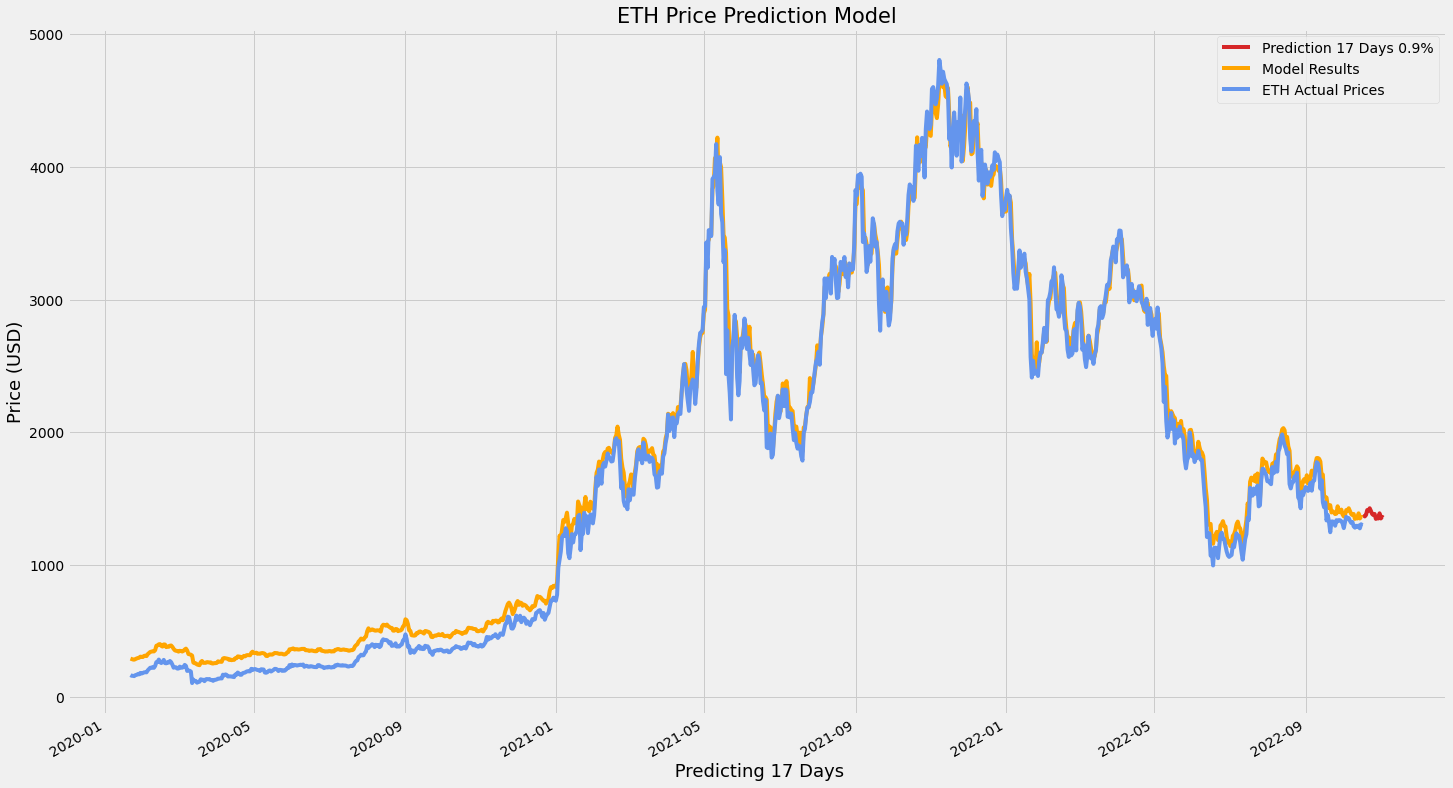

<module 'matplotlib.pylab' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pylab.py'>

In [19]:
import matplotlib.dates as mdates

def plot_model():
  plt.figure(figsize=(22,14))
  plt.plot(forecast_df.forecast, color='tab:red', label = f'Prediction {forecast_days} Days {accuracy_score}%')
  plt.plot(model_predictions_df, color='orange', label = 'Model Results')
  plt.plot(crypto_df.close, color='cornflowerblue', label = f'{symbol} Actual Prices')
  plt.title(f'{symbol} Price Prediction Model', fontsize=21)
  plt.xlabel(f' Predicting {forecast_days} Days', fontsize=18)
  plt.ylabel('Price (USD)', fontsize=18)
  plt.legend(loc='upper right')
  plt.gcf().autofmt_xdate()

  plt.show()

  return plt

plot_model()

In [20]:
#Dateframe columns for future predictions based on n forecast days
forecast_df.style.background_gradient(axis=None, low=0.75, high=2)

,forecast
Date,
2022-10-18 00:00:00,1379.505397
2022-10-19 00:00:00,1364.763059
2022-10-20 00:00:00,1375.960127
2022-10-21 00:00:00,1413.049829
2022-10-22 00:00:00,1408.578486
2022-10-23 00:00:00,1426.557403
2022-10-24 00:00:00,1405.753494
2022-10-25 00:00:00,1382.929062
2022-10-26 00:00:00,1375.118242
